# imports and uploads

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from collections import Counter
%matplotlib inline

In [2]:
# upload data
cpath = os.getcwd() #assumes scalar_df_females is in the same path as the notebook
scalar_df = pd.read_csv(cpath+'/scalar_df_female.csv')
scalar_df_subset=scalar_df.copy()

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [3]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")

In [4]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='copper', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    fig.savefig(data_loc +name+'.pdf', bbox_inches='tight')

# scalars per phase

In [5]:
scalar_mean = scalar_df_subset.groupby(['group','mouse','rep','SubjectName'], as_index=False).quantile(np.arange(0.2, 1, 0.2))

# convert px to mm
pxmm = scalar_mean.area_mm.mean()/scalar_mean.area_px.mean()
scalar_mean['dist_to_center_px'] = scalar_mean['dist_to_center_px']*pxmm

# convert mm to mm/sec
scalar_mean['velocity_2d_mm'] = scalar_mean['velocity_2d_mm']*30
scalar_mean['velocity_3d_mm'] = scalar_mean['velocity_3d_mm']*30

In [6]:
phase_scalars = scalar_mean[['mouse','group','rep','SubjectName','velocity_3d_mm','velocity_2d_mm','dist_to_center_px']]

## Compute total distance traveled

In [7]:
def compute_diff_dist(scalar_df: pd.DataFrame):
    scalar_df = scalar_df[['centroid_x_mm', 'centroid_y_mm']].dropna()
    return np.sqrt((scalar_df[['centroid_x_mm', 'centroid_y_mm']].diff()**2).sum(1)).sum()/1000
dist_df = scalar_df_subset.groupby(by=['group', 'mouse','rep','SubjectName']).apply(compute_diff_dist).reset_index()
dist_df = dist_df.rename(columns={0:'dist_traveled'})

In [8]:
phase_mouse=dist_df.groupby(['mouse', 'group','rep','SubjectName']).mean().reset_index()

In [9]:
vals = ['velocity_2d_mm', 'velocity_3d_mm', 'dist_to_center_px']
melted = phase_scalars.reset_index().melt(id_vars=['mouse', 'group', 'rep','SubjectName','level_1'], value_vars=vals)
win=melted.pivot_table(index=['mouse', 'group', 'rep','SubjectName'], columns=['variable', 'level_1'], values='value').reindex()

## Compute time in center

In [10]:
## calaulate time in center
# convert px to mm
pxmm = scalar_df_subset.area_mm.mean()/scalar_df_subset.area_px.mean()
scalar_df_subset['dist_center_mm'] = scalar_df_subset['dist_to_center_px']*pxmm

scalar_mean['center_time']=0
thresh_dist = 110
dist_df = scalar_df_subset[scalar_df_subset['dist_center_mm']<thresh_dist]
a = Counter(dist_df['SubjectName']).items()
# match time in center to specific session
for i in a:
    scalar_mean.center_time[scalar_mean.SubjectName==i[0]] = i[1]    
    
center_time_temp=scalar_mean.groupby(['mouse', 'group','rep','SubjectName'])['center_time'].mean().reset_index()

In [11]:
## add time in center and distance traveled to the dataframe

In [12]:
mice = sorted(phase_mouse.SubjectName.unique())
for i,m in enumerate(mice):
    win.loc[pd.IndexSlice[:, :, :, [m]], 'dist_traveled'] = \
     float(phase_mouse['dist_traveled'][phase_mouse.SubjectName==m].values)
    win.loc[pd.IndexSlice[:, :, :, [m]], 'center_time'] = \
     float(center_time_temp['center_time'][center_time_temp.SubjectName==m].values)
phase_scalars = win.reset_index()

## Decode phase from all scalars combined

In [21]:
# choose mice that have at least 3 phases and 10 repetitions each
minp = 3
minr=10
minmp = 7
phase_counts = phase_scalars.groupby('mouse')['group'].nunique()
rep_counts = phase_scalars.groupby('mouse')['rep'].nunique()
keep_mice = list(set(phase_counts[phase_counts >= minp].index) & set(rep_counts[rep_counts >= minr].index))

data = phase_scalars[phase_scalars['mouse'].isin(keep_mice)].groupby(['group','rep','mouse']).mean().reset_index()

In [22]:
it=1000
leave = 'mouse'
predict='group'
minum=10

In [23]:
#decoder
clf = RandomForestClassifier(n_estimators = 250,class_weight='balanced')
out = defaultdict(list)
for i in tqdm(range(it)):
    sm = data.copy()
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]

        X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['y_true'].extend(a)
    out['y_pred'].extend(b)
    out['acc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

#shuffle
for i in tqdm(range(it)):
    sm = data.copy()
    sm['group'] = sm.groupby('mouse')['group'].transform(np.random.permutation)
    a,b= [],[]
    for leaveout in sm[leave].unique():
        train = sm[sm[leave] != leaveout]
        test = sm[sm[leave] == leaveout]

        X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_test = test[predict].to_numpy()

        #balance labels
        btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
        X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
        y_train = btrain[predict].to_numpy()

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        a.append(y_test)
        b.append(y_hat)
    out['sy_true'].extend(a)
    out['sy_pred'].extend(b)
    out['sacc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
# save decoder results
decoder ='phase_decoder_all_scalars'
with open(data_loc+decoder+'.dat', 'wb') as f:
    pickle.dump((out), f)

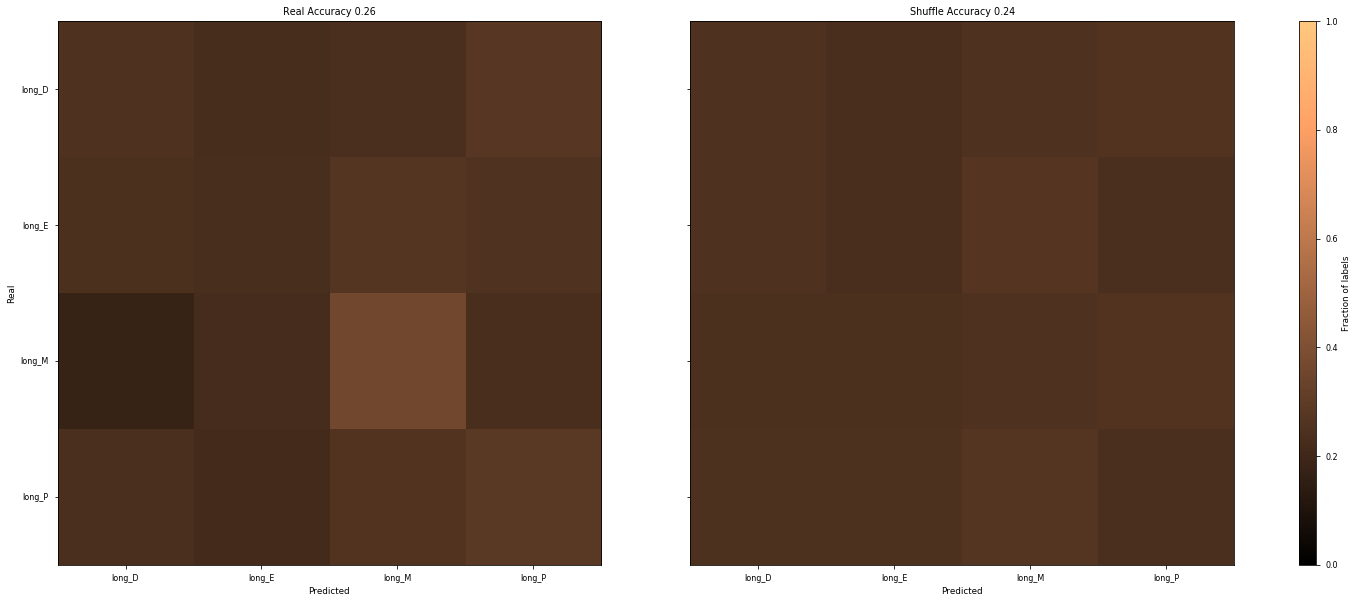

In [25]:
# plot confusion matrix
plot_cm(np.concatenate(out['y_true']),np.concatenate(out['y_pred']),
        np.concatenate(out['sy_true']),np.concatenate(out['sy_pred']),decoder+'_confusion')

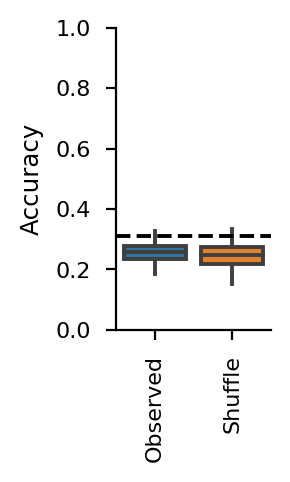

In [26]:
# plot accuracy
shuff_v=pd.DataFrame()
shuff_v['accuracy'] = out['acc']
shuff_v['shuff_accuracy'] = out['sacc']
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=shuff_v, showfliers=False, showcaps=False, order=['accuracy', 'shuff_accuracy'])
plt.xticks(ticks=[0, 1], labels=['Observed', 'Shuffle'], rotation=90)
ax.set(ylabel='Accuracy')
plt.ylim([0,1])
plt.axhline(y=shuff_v['shuff_accuracy'].quantile(.95), xmin=0, xmax=1, ls='--', c='k') #plot threshold for significance 
sns.despine()
fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

In [27]:
# is it significant?
loc = int(np.floor(len(shuff_v['shuff_accuracy'])*0.95))
a=np.argsort(shuff_v['shuff_accuracy'])
print('95th precentile of suffle is: ',shuff_v['shuff_accuracy'].quantile(.95)) # [a].to_numpy()[loc])
print('mean of decoding distribution is: ',np.mean(np.array(shuff_v['accuracy'])))
print ('mean shuffle accuracy is: ',np.mean(shuff_v['shuff_accuracy']))

95th precentile of suffle is:  0.3114754098360656
mean of decoding distribution is:  0.2573770491803279
mean shuffle accuracy is:  0.24377049180327867


## Decode phase based on each scalar

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

phase_decoder_velocity_3d_mm


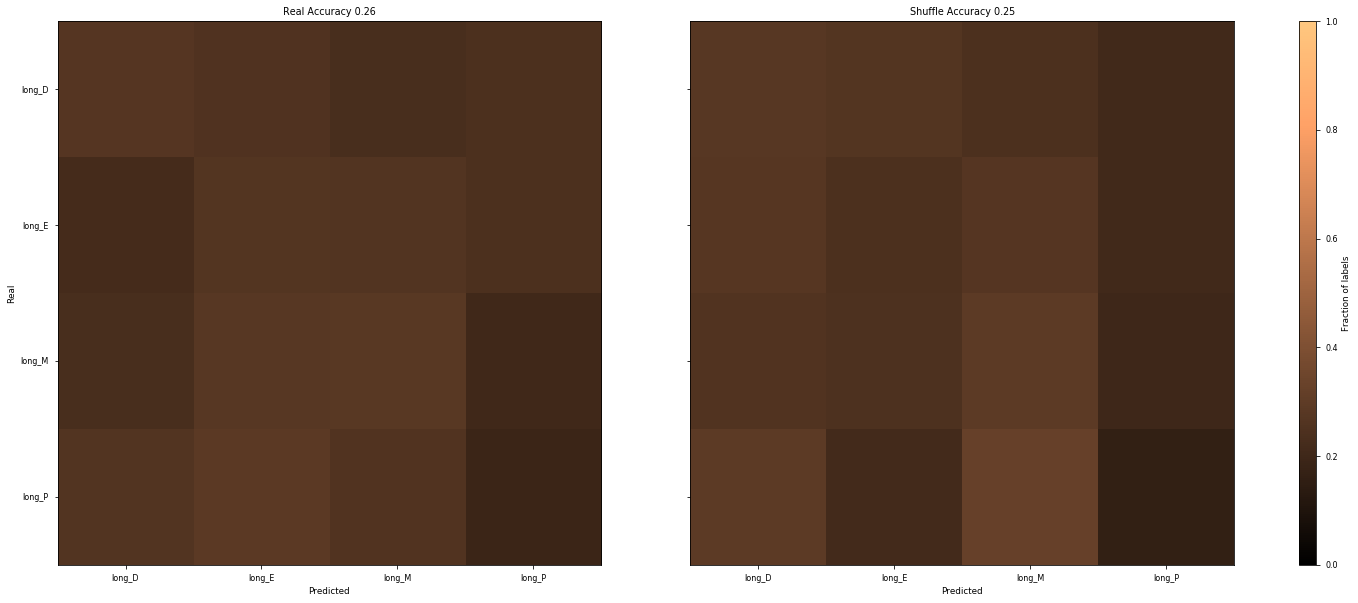

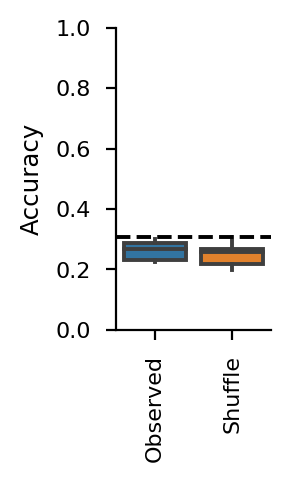

95th precentile of suffle is:  0.30601092896174864
mean of decoding distribution is:  0.26229508196721313
mean shuffle accuracy is:  0.25136612021857924


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

phase_decoder_velocity_2d_mm


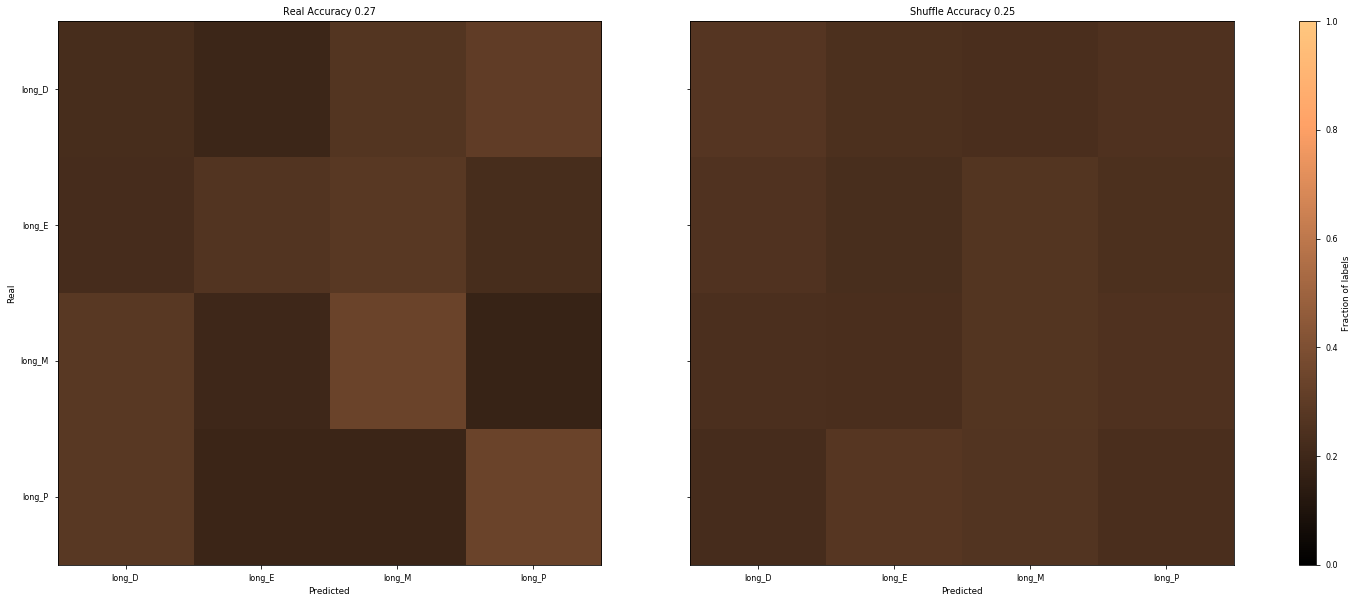

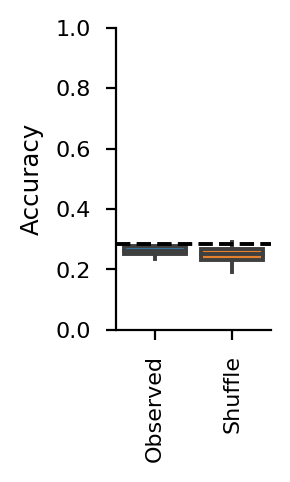

95th precentile of suffle is:  0.28469945355191256
mean of decoding distribution is:  0.2683060109289618
mean shuffle accuracy is:  0.24918032786885247


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

phase_decoder_dist_to_center_px


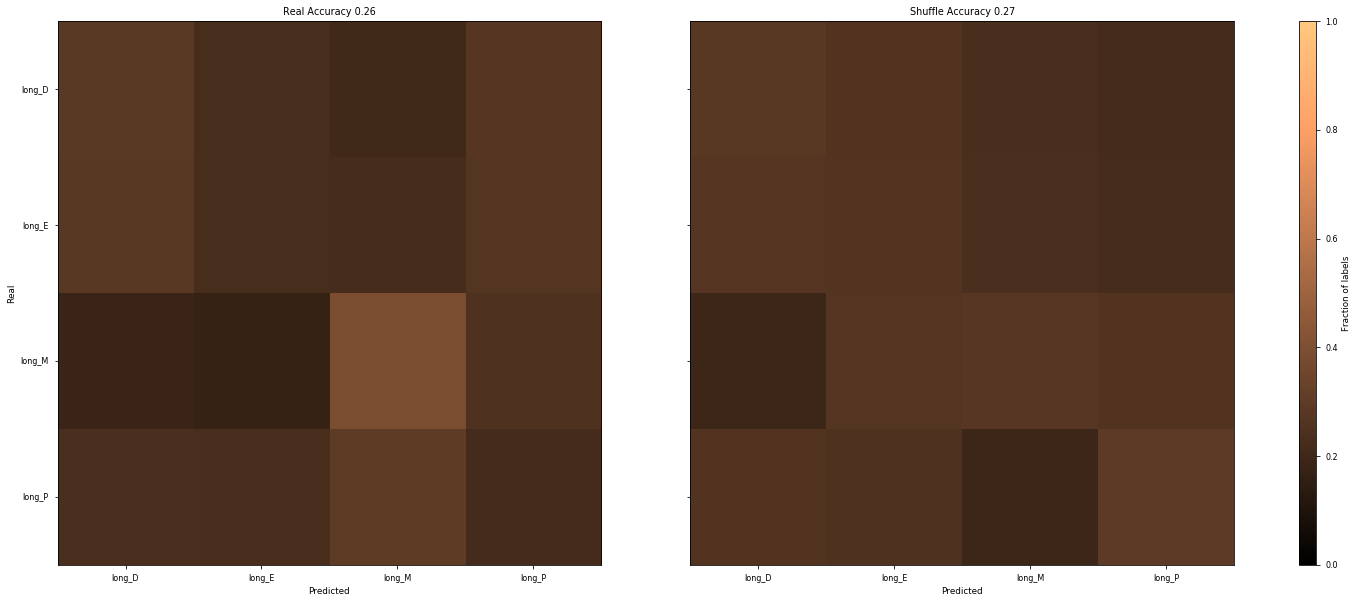

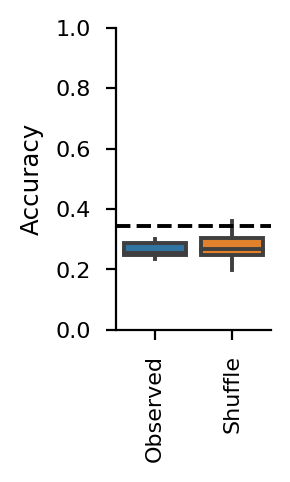

95th precentile of suffle is:  0.3434426229508196
mean of decoding distribution is:  0.26284153005464483
mean shuffle accuracy is:  0.2748633879781421


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

phase_decoder_center_time


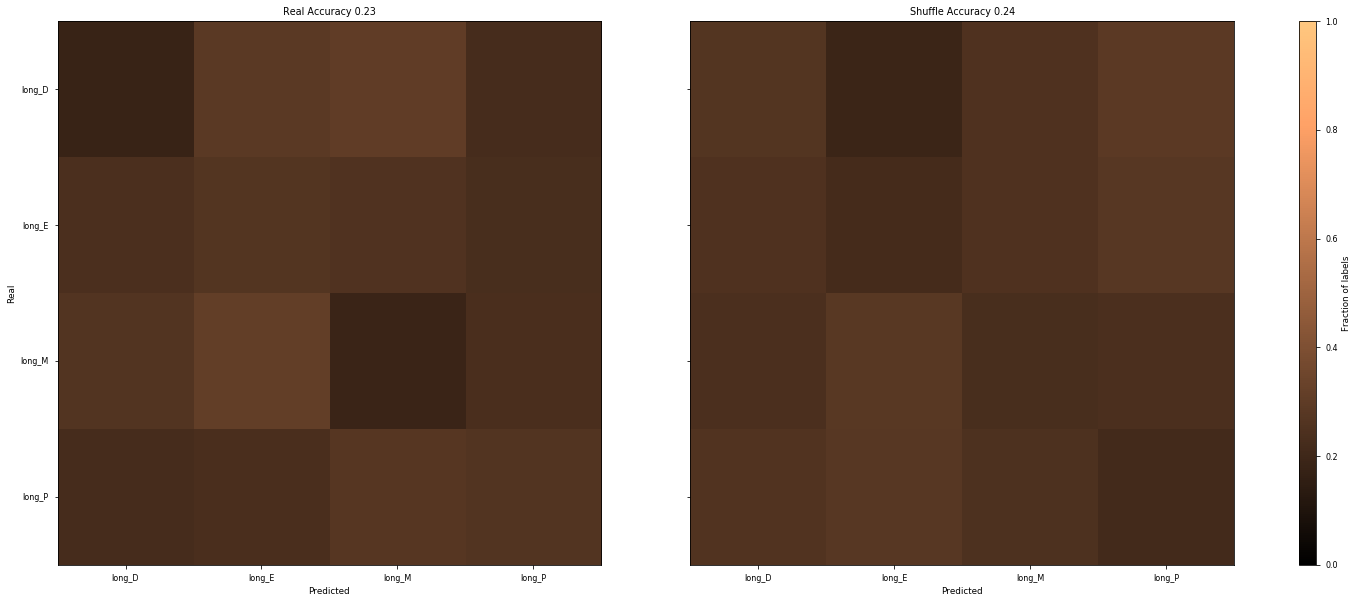

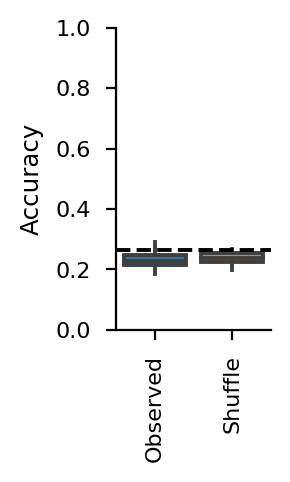

95th precentile of suffle is:  0.2653005464480874
mean of decoding distribution is:  0.23114754098360657
mean shuffle accuracy is:  0.2360655737704918


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

phase_decoder_dist_traveled


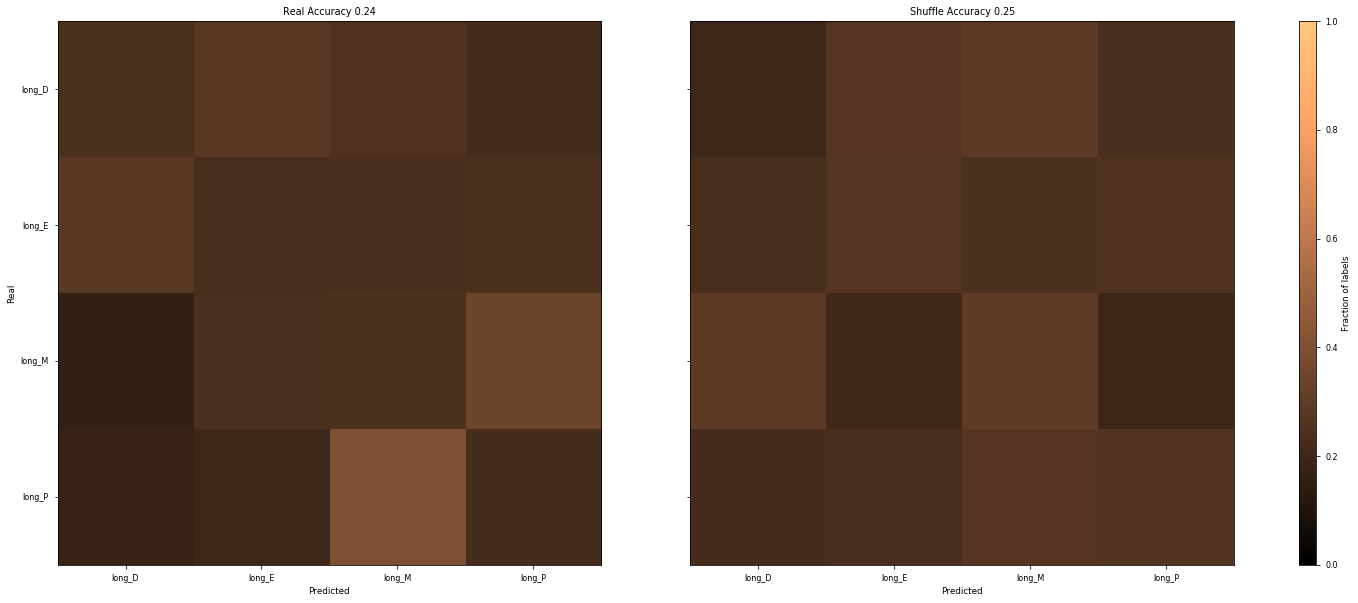

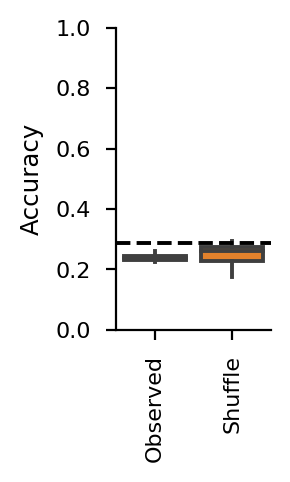

95th precentile of suffle is:  0.28770491803278686
mean of decoding distribution is:  0.23934426229508196
mean shuffle accuracy is:  0.2491803278688524


In [20]:
scalars = ['velocity_3d_mm','velocity_2d_mm','dist_to_center_px','center_time','dist_traveled']

for ss in scalars:
    data2 = data[['group','rep','mouse',ss]].copy()

    #decoder
    clf = RandomForestClassifier(n_estimators = 250,class_weight='balanced')
    out = defaultdict(list)
    for i in tqdm(range(it)):
        sm = data2.copy()
        a,b= [],[]
        for leaveout in sm[leave].unique():
            train = sm[sm[leave] != leaveout]
            test = sm[sm[leave] == leaveout]

            X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
            y_test = test[predict].to_numpy()

            #balance labels
            btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
            X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
            y_train = btrain[predict].to_numpy()

            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)
            a.append(y_test)
            b.append(y_hat)
        out['y_true'].extend(a)
        out['y_pred'].extend(b)
        out['acc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))

    #shuffle
    for i in tqdm(range(it)):
        sm = data2.copy()
        sm['group'] = sm.groupby('mouse')['group'].transform(np.random.permutation)
        a,b= [],[]
        for leaveout in sm[leave].unique():
            train = sm[sm[leave] != leaveout]
            test = sm[sm[leave] == leaveout]

            X_test = test.drop(['group','rep','mouse'], axis=1).to_numpy()
            y_test = test[predict].to_numpy()

            #balance labels
            btrain = train.groupby(predict).apply(lambda x: x.sample(n=minum-1,replace=False)).reset_index(drop=True) # new balanced df
            X_train = btrain.drop(['group','rep','mouse'], axis=1).to_numpy()
            y_train = btrain[predict].to_numpy()

            clf.fit(X_train, y_train)
            y_hat = clf.predict(X_test)
            a.append(y_test)
            b.append(y_hat)
        out['sy_true'].extend(a)
        out['sy_pred'].extend(b)
        out['sacc'].append(accuracy_score(np.concatenate(a),np.concatenate(b)))
        
    # save figures
    decoder ='phase_decoder_'+ss 
    print (decoder)

    # decoding 
    with open(data_loc+decoder+'.dat', 'wb') as f:
        pickle.dump((out), f)
        
    # plot
    #confusion matrix
    plot_cm(np.concatenate(out['y_true']),np.concatenate(out['y_pred']),
        np.concatenate(out['sy_true']),np.concatenate(out['sy_pred']),decoder+'_confusion')
    
    #accuracy
    shuff_v=pd.DataFrame()
    shuff_v['accuracy'] = out['acc']
    shuff_v['shuff_accuracy'] = out['sacc']
    fig = plt.figure(figsize=(1, 2))
    fig.dpi = 200
    ax = sns.boxplot(data=shuff_v, showfliers=False, showcaps=False, order=['accuracy', 'shuff_accuracy'])
    plt.xticks(ticks=[0, 1], labels=['Observed', 'Shuffle'], rotation=90)
    ax.set(ylabel='Accuracy')
    plt.ylim([0,1])
    plt.axhline(y=shuff_v['shuff_accuracy'].quantile(.95), xmin=0, xmax=1, ls='--', c='k')
    sns.despine()
    plt.show()
    fig.savefig(data_loc +decoder+'.pdf', bbox_inches='tight')
    
    # is it significant?
    loc = int(np.floor(len(shuff_v['shuff_accuracy'])*0.95))
    a=np.argsort(shuff_v['shuff_accuracy'])
    print('95th precentile of suffle is: ',shuff_v['shuff_accuracy'].quantile(.95)) # [a].to_numpy()[loc])
    print('mean of decoding distribution is: ',np.mean(np.array(shuff_v['accuracy'])))
    print ('mean shuffle accuracy is: ',np.mean(shuff_v['shuff_accuracy']))